In [1]:
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

NUM_CONT_FEATS = 10 

def compute_normalization_stats(train_sequences, num_cont_feats=NUM_CONT_FEATS):
    """
    train_sequences: список np.ndarray [T, F]
    Считаем mean/std только по первым num_cont_feats признакам на всём трейн-сете.
    """
    all_rows = []
    for seq in train_sequences:
        base = seq[:, :num_cont_feats]  # только continuous
        all_rows.append(base.reshape(-1, num_cont_feats))
    all_rows = np.concatenate(all_rows, axis=0)

    mean = all_rows.mean(axis=0)
    std = all_rows.std(axis=0)
    std[std < 1e-6] = 1.0 
    return mean, std


def apply_normalization(sequences, mean, std, num_cont_feats=NUM_CONT_FEATS):
    """
    Применяем (x - mean) / std к первым num_cont_feats фичам.
    Остальное (бинарные и one-hot) не трогаем.
    """
    normed = []
    for seq in sequences:
        seq = seq.copy()
        seq[:, :num_cont_feats] = (seq[:, :num_cont_feats] - mean) / std
        normed.append(seq)
    return normed

def build_encoders(pbp: pd.DataFrame) -> Dict[str, Dict[str, int]]:
    """
    Строим один словарь для комбинированного типа события:
    combined_type = EVENT_TYPE  или  EVENT_TYPE + SECONDARY_TYPE
    (secondary_type с NaN не даёт отдельной категории)
    """
    encoders: Dict[str, Dict[str, int]] = {}

    et = (
        pbp["event_type"]
        .astype(str)
        .str.upper()
    )

    st = pbp["secondary_type"].astype("string")

    combined = []
    for e, s in zip(et, st):
        if pd.isna(s) or s == "":
            combined.append(e)                 
        else:
            combined.append(f"{e}_{str(s).upper()}") 

    combined_unique = sorted(set(combined))
    encoders["event_type_combined"] = {ct: i for i, ct in enumerate(combined_unique)}

    return encoders


#2 Построение выборок по минутам периода
def build_game_sequences(
    pbp: pd.DataFrame,
    encoders: Dict[str, Dict[str, int]],
    min_events_per_game: int = 50,
    window_size: int = 50,
    max_period: int = 3,  # берём только 1–3 периоды
) -> Tuple[List[np.ndarray], List[int], List[dict]]:
    """
    Делаем выборки для обучения:

    Каждая выборка = 50 последних событий перед минутной отметкой в периоде.
    Лейбл = результат периода: 1, если home ведёт после конца периода, иначе 0.

    Возвращает:
      - X_list: список np.ndarray[window_size, F]
      - y_list: список int (0/1)
      - meta_list: список словарей с метой:
            { "game_id": ..., "period": ..., "minute_in_period": ..., "evant_time": ... }
    """

    required_cols = [
        "game_id", "event_type", "period", "game_seconds",
        "home_score", "away_score",
        "event_team_type",
        "x_fixed", "y_fixed",
        "shot_distance", "shot_angle",
        "home_skaters", "away_skaters",
        "extra_attacker",
        "secondary_type",
    ]
    missing = [c for c in required_cols if c not in pbp.columns]
    if missing:
        raise ValueError(f"Missing required columns in pbp: {missing}")

    # сортируем внутри игры по времени
    pbp_sorted = pbp.sort_values(["game_id", "game_seconds"]).reset_index(drop=True)

    X_list: List[np.ndarray] = []
    y_list: List[int] = []
    meta_list: List[dict] = []

    event_type_to_idx = encoders["event_type_combined"]

    for game_id, g in pbp_sorted.groupby("game_id", sort=False):
        if len(g) < max(min_events_per_game, window_size):
            continue

        g = g.reset_index(drop=True)
        N = len(g)

        # общие массивы по игре
        game_seconds = g["game_seconds"].astype(float).values
        max_t = max(game_seconds.max(), 1.0)
        t_norm = game_seconds / max_t

        period_arr = g["period"].astype(int).values

        home_score_all = g["home_score"].astype(float).values
        away_score_all = g["away_score"].astype(float).values
        score_diff_all = home_score_all - away_score_all

        home_skaters_all = g["home_skaters"].astype(float).fillna(0.0).values
        away_skaters_all = g["away_skaters"].astype(float).fillna(0.0).values

        extra_attacker_all = g["extra_attacker"].astype(float).fillna(0.0).values

        is_home_event_all = g["event_team_type"].eq("home").fillna(False).astype(float).values
        is_away_event_all = g["event_team_type"].eq("away").fillna(False).astype(float).values

        x_fixed_all = g["x_fixed"].astype(float).fillna(0.0).values
        y_fixed_all = g["y_fixed"].astype(float).fillna(0.0).values
        shot_distance_all = g["shot_distance"].astype(float).fillna(0.0).values
        shot_angle_all = g["shot_angle"].astype(float).fillna(0.0).values

        event_type_all = g["event_type"].astype(str).str.upper().values

        team_type_all = (
            g["event_team_type"]
            .fillna("unknown")   
            .astype(str)
            .str.lower()
            .values              
        )

        cont_all = np.stack(
            [
                t_norm,
                home_score_all,
                away_score_all,
                score_diff_all,
                home_skaters_all,
                away_skaters_all,
                x_fixed_all,
                y_fixed_all,
                shot_distance_all,
                shot_angle_all,
            ],
            axis=1,
        ).astype(np.float32)

        # бинарные фичи
        binary_all = np.stack(
            [
                extra_attacker_all,
                is_home_event_all,
                is_away_event_all,
            ],
            axis=1,
        ).astype(np.float32)

        # period -> one-hot
        num_periods = max_period
        period_ohe_all = np.zeros((N, num_periods), dtype=np.float32)
        for i, p in enumerate(period_arr):
            if 1 <= p <= num_periods:
                period_ohe_all[i, p - 1] = 1.0
        
        et = g["event_type"].astype(str).str.upper().values
        st = g["secondary_type"].astype("string").values

        combined = []
        for e, s in zip(et, st):
            if pd.isna(s) or s == "":
                combined.append(e)
            else:
                combined.append(f"{e}_{str(s).upper()}")

        num_types = len(event_type_to_idx)
        type_ohe_all = np.zeros((N, num_types), dtype=np.float32)
        for i, ct in enumerate(combined):
            j = event_type_to_idx.get(ct)
            if j is not None:
                type_ohe_all[i, j] = 1.0

        # по периодам
        for p in range(1, max_period + 1):
            period_mask = (period_arr == p)
            if not period_mask.any():
                continue

            idxs_p = np.where(period_mask)[0]
            times_p = game_seconds[idxs_p]

            # 20 минут в периоде → минутные границы
            period_start = (p - 1) * 20 * 60  # 0, 1200, 2400
            # minute_in_period = 1..20
            for minute_in_period in range(1, 21):
                threshold = period_start + 60 * minute_in_period

                # ищем первое событие этого периода, у которого game_seconds >= threshold
                pos_in_p = np.searchsorted(times_p, threshold, side="left")
                if pos_in_p >= len(times_p):
                    continue

                idx_event = idxs_p[pos_in_p] 
                if idx_event < window_size - 1:
                    # недостаточно 50 предыдущих событий
                    continue

                future_idxs = idxs_p[idxs_p > idx_event]

                label = 2  # по умолчанию: голов больше не будет
                for fi in future_idxs:
                    if event_type_all[fi] == "GOAL":
                        team = team_type_all[fi]
                        if team == "home":
                            label = 0  # следующая забьёт домашняя
                            break
                        elif team == "away":
                            label = 1  # следующая забьёт гостевая
                            break
                        else:
                            # goal с непонятной командой — игнорируем и смотрим дальше
                            continue
                
                # окно из 50 событий 
                start_idx = idx_event - window_size + 1
                end_idx = idx_event + 1  # срез до end_idx не включительно
                window_idx = np.arange(start_idx, end_idx)

                cont = cont_all[window_idx]            # [T, 10]
                binary = binary_all[window_idx]        # [T, 3]
                period_ohe = period_ohe_all[window_idx]# [T, 3]
                type_ohe = type_ohe_all[window_idx]    # [T, num_types]

                feat_mat = np.concatenate(
                    [cont, binary, period_ohe, type_ohe],
                    axis=1
                )  

                X_list.append(feat_mat)
                y_list.append(label)
                meta_list.append(
                    {
                        "game_id": game_id,
                        "period": int(p),
                        "minute_in_period": int(minute_in_period),
                        "event_time": float(game_seconds[idx_event]),
                    }
                )

    y_arr = np.array(y_list, dtype=float)
    print("y NaN:", np.isnan(y_arr).sum())
    print("y уникальные значения:", np.unique(y_arr))

    return X_list, y_list, meta_list

# Dataset + collate_fn для PyTorch

class HockeySeqDataset(Dataset):
    """
    один объект = одна выборка (50 событий).
    x: [T, F], y: 0/1 (home ведёт после периода), meta: словарь с метой.
    """
    def __init__(self, sequences: List[np.ndarray], labels: List[int], metas: List[dict]):
        assert len(sequences) == len(labels) == len(metas)
        self.sequences = sequences
        self.labels = labels
        self.metas = metas

    def __len__(self) -> int:
        return len(self.sequences)

    def __getitem__(self, idx: int):
        x = torch.from_numpy(self.sequences[idx])  # [T, F]
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        meta = self.metas[idx]
        return x, y, meta


def collate_pad(batch):
    """
    Пакуем батч в общий тензор [B, T_max, F] + маска [B, T_max]
    и прокидываем meta как список словарей.
    """
    xs, ys, metas = zip(*batch)  # добавили metas
    lengths = [x.size(0) for x in xs]
    F = xs[0].size(1)
    B = len(xs)
    T_max = max(lengths)

    padded = xs[0].new_zeros((B, T_max, F))
    mask = torch.zeros((B, T_max), dtype=torch.bool)  # True на реальных шагах

    for i, x in enumerate(xs):
        L = x.size(0)
        padded[i, :L] = x
        mask[i, :L] = True

    y = torch.stack(ys)
    metas = list(metas)  # просто список словарей
    return padded, y, mask, metas


In [2]:
class LSTMOutcomeModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 128,
                 num_layers: int = 2, dropout: float = 0.2,
                 num_classes: int = 3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=False
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        out, (h_n, c_n) = self.lstm(x)
        last_indices = (mask.sum(dim=1) - 1).clamp(min=0)
        batch_idx = torch.arange(x.size(0), device=x.device)
        last_hidden = out[batch_idx, last_indices]
        logits = self.fc(self.dropout(last_hidden))  # [B, num_classes]
        return logits


class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model, dtype=torch.float32)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, T, d_model]
        T = x.size(1)
        x = x + self.pe[:, :T]
        return x


class TransformerOutcomeModel(nn.Module):
    def __init__(
        self,
        input_dim: int,
        d_model: int = 128,
        nhead: int = 4,
        num_layers: int = 3,
        dim_feedforward: int = 256,
        dropout: float = 0.2,
        num_classes: int = 3,
    ):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        src_key_padding_mask = ~mask
        enc_out = self.encoder(x, src_key_padding_mask=src_key_padding_mask)
        # enc_out: [B, T, d_model]
        # mask:    [B, T]  (True = реальный шаг)
        
        mask_float = mask.float()                          # [B, T]
        enc_out_masked = enc_out * mask_float.unsqueeze(-1)  # [B, T, d_model]
        
        sum_vec = enc_out_masked.sum(dim=1)                # [B, d_model]
        len_vec = mask_float.sum(dim=1).clamp(min=1.0)     # [B]
        
        pooled = sum_vec / len_vec.unsqueeze(-1)           # [B, d_model]
        
        logits = self.fc(self.dropout(pooled))             # [B, num_classes]
        return logits

class Chomp1d(nn.Module):
    def __init__(self, chomp_size: int):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, C, L + padding]
        if self.chomp_size == 0:
            return x
        return x[:, :, :-self.chomp_size]


class TemporalBlock(nn.Module):
    """
    Один TCN-блок: два dilated Conv1d + residual + dropout.
    """
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        dilation: int,
        dropout: float
    ):
        super().__init__()
        padding = (kernel_size - 1) * dilation

        self.conv1 = nn.Conv1d(
            in_channels, out_channels,
            kernel_size=kernel_size,
            padding=padding,
            dilation=dilation
        )
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(
            out_channels, out_channels,
            kernel_size=kernel_size,
            padding=padding,
            dilation=dilation
        )
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        # residual-путь 
        self.downsample = (
            nn.Conv1d(in_channels, out_channels, kernel_size=1)
            if in_channels != out_channels
            else None
        )
        self.out_relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: [B, C_in, T]
        """
        out = self.conv1(x)
        out = self.chomp1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.chomp2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        return self.out_relu(out + res)   # residual + nonlinearity


class TCNOutcomeModel(nn.Module):
    """
    TCN-модель: стек TemporalBlock'ов + глобальный пуллинг по времени.
    Вход: x [B, T, F], mask [B, T]
    Выход: logits [B, num_classes]
    """
    def __init__(
        self,
        input_dim: int,
        num_channels: List[int] = None,
        kernel_size: int = 3,
        dropout: float = 0.3,
        num_classes: int = 3,
    ):
        super().__init__()
        if num_channels is None:
            num_channels = [128, 128, 128]

        layers = []
        in_ch = input_dim  
        dilation = 1
        for out_ch in num_channels:
            layers.append(
                TemporalBlock(
                    in_channels=in_ch,
                    out_channels=out_ch,
                    kernel_size=kernel_size,
                    dilation=dilation,
                    dropout=dropout,
                )
            )
            in_ch = out_ch
            dilation *= 2  

        self.network = nn.Sequential(*layers)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_channels[-1], num_classes)

    def forward(self, x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        """
        x: [B, T, F]
        mask: [B, T] (True на реальных шагах)
        """
        # Conv1d ожидает [B, C, L] => C = F, L = T
        x = x.transpose(1, 2)  # [B, F, T]

        out = self.network(x)  # [B, C, T]

        # masked global average pooling по времени
        mask_float = mask.float().unsqueeze(1)  # [B, 1, T]
        out = out * mask_float                  # зануляем паддинг
        sum_out = out.sum(dim=2)                # [B, C]
        lengths = mask_float.sum(dim=2).clamp(min=1.0)  # [B, 1]
        pooled = sum_out / lengths              # [B, C]

        logits = self.fc(self.dropout(pooled))  # [B, num_classes]
        return logits

# Обучение и валидация

def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device
) -> float:
    model.train()
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    for x, y, mask, metas in loader:
        x = x.to(device)
        y = y.to(device)         
        mask = mask.to(device)
        optimizer.zero_grad()
        logits = model(x, mask)   # [B, 3]
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)


@torch.no_grad()
def evaluate(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device
) -> Tuple[float, float]:
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0
    correct = 0
    total = 0
    for x, y, mask, metas in loader:
        x = x.to(device)
        y = y.to(device)         # long
        mask = mask.to(device)
        logits = model(x, mask)  # [B, 3]
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)

        preds = logits.argmax(dim=1)  # [B]
        correct += (preds.cpu() == y.cpu()).sum().item()
        total += x.size(0)
    return total_loss / len(loader.dataset), correct / max(total, 1)


@torch.no_grad()
def evaluate_by_minute_and_period(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device
) -> None:
    """
    Считает accuracy на валидации отдельно для каждой (period, minute_in_period).
    """
    model.eval()
    bucket_stats = {}  # (period, minute) -> {"correct": int, "total": int}

    for x, y, mask, metas in loader:
        x = x.to(device)
        y = y.to(device)
        mask = mask.to(device)

        logits = model(x, mask)          # [B, 3]
        preds = logits.argmax(dim=1).cpu()  # [B]
        y_true = y.cpu()                    # [B]

        correct_batch = (preds == y_true).numpy()

        for is_corr, meta in zip(correct_batch, metas):
            period = int(meta["period"])
            minute = int(meta["minute_in_period"])
            key = (period, minute)
            if key not in bucket_stats:
                bucket_stats[key] = {"correct": 0, "total": 0}
            bucket_stats[key]["correct"] += int(is_corr)
            bucket_stats[key]["total"] += 1

    periods = sorted({p for (p, m) in bucket_stats.keys()})
    for p in periods:
        print(f"\n=== Period {p} ===")
        minutes = sorted(m for (pp, m) in bucket_stats.keys() if pp == p)
        for m in minutes:
            stats = bucket_stats[(p, m)]
            acc = stats["correct"] / stats["total"]
            print(f"Minute {m:2d}: acc={acc:.3f} (n={stats['total']})")



In [3]:
batch_size = 64
num_epochs = 20
lr = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Загрузка данных
df1 = pd.read_csv("/kaggle/input/data-21-24/play_by_play_2021_22.csv", encoding="latin1")
df2 = pd.read_csv("/kaggle/input/data-21-24/play_by_play_2022_23.csv", encoding="latin1")
df3 = pd.read_csv("/kaggle/input/data-21-24/play_by_play_2023_24.csv", encoding="latin1")
df = pd.concat([df1, df2, df3], ignore_index=True)

# убираем замены
df_model = df[df["event_type"] != "CHANGE"].copy()

encoders = build_encoders(df_model)
X_list, y_list, meta_list = build_game_sequences(
    df_model,
    encoders,
    min_events_per_game=50,
    window_size=50,
    max_period=3,
)

# meta_list содержит game_id
all_game_ids = [m["game_id"] for m in meta_list]
unique_game_ids = sorted(set(all_game_ids))

# 80% матчей в train, 20% в val
rng = np.random.default_rng(seed=42)
rng.shuffle(unique_game_ids)

n_games = len(unique_game_ids)
n_train_games = int(0.8 * n_games)
train_game_ids = set(unique_game_ids[:n_train_games])
val_game_ids   = set(unique_game_ids[n_train_games:])

train_idx = [i for i, m in enumerate(meta_list) if m["game_id"] in train_game_ids]
val_idx   = [i for i, m in enumerate(meta_list) if m["game_id"] in val_game_ids]

X_train_raw = [X_list[i] for i in train_idx]
y_train     = [y_list[i] for i in train_idx]
meta_train  = [meta_list[i] for i in train_idx]

X_val_raw = [X_list[i] for i in val_idx]
y_val     = [y_list[i] for i in val_idx]
meta_val  = [meta_list[i] for i in val_idx]

mean, std = compute_normalization_stats(X_train_raw)

# применяем к train и val
X_train = apply_normalization(X_train_raw, mean, std)
X_val   = apply_normalization(X_val_raw,   mean, std)

# строим датасеты уже из нормализованных фич
train_ds = HockeySeqDataset(X_train, y_train, meta_train)
val_ds   = HockeySeqDataset(X_val,   y_val,   meta_val)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  collate_fn=collate_pad)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, collate_fn=collate_pad)


input_dim = train_ds[0][0].shape[1]

model_type = "transformer"   # варианты: "transformer", "lstm", "tcn"

if model_type == "transformer":
    model = TransformerOutcomeModel(
        input_dim=input_dim,
        d_model=128,
        nhead=4,
        num_layers=2,
        dim_feedforward=256,
        dropout=0.3,
        num_classes=3,
    )
elif model_type == "lstm":
    model = LSTMOutcomeModel(
        input_dim=input_dim,
        hidden_dim=128,
        num_layers=3,
        dropout=0.3,
        num_classes=3,
    )
elif model_type == "tcn":
    model = TCNOutcomeModel(
        input_dim=input_dim,
        num_channels=[128, 128, 128],
        kernel_size=3,
        dropout=0.3,
        num_classes=3,
    )
else:
    raise ValueError(f"Unknown model_type: {model_type}")

model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',  
    factor=0.5,  
    patience=2,  
    verbose=True
)

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, device)
    print(f"Epoch {epoch}: "
          f"train_loss={train_loss:.4f} "
          f"val_loss={val_loss:.4f} "
          f"val_acc={val_acc:.4f}")

    scheduler.step(val_loss)

Device: cuda


/tmp/ipykernel_47/306942774.py:9: DtypeWarning: Columns (49,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv("/kaggle/input/data-21-24/play_by_play_2021_22.csv", encoding="latin1")
/tmp/ipykernel_47/306942774.py:10: DtypeWarning: Columns (48,49,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv("/kaggle/input/data-21-24/play_by_play_2022_23.csv", encoding="latin1")
/tmp/ipykernel_47/306942774.py:11: DtypeWarning: Columns (42,43,49,50,120,136) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv("/kaggle/input/data-21-24/play_by_play_2023_24.csv", encoding="latin1")


y NaN: 0
y уникальные значения: [0. 1. 2.]


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Epoch 1: train_loss=0.9468 val_loss=0.9295 val_acc=0.5212
Epoch 2: train_loss=0.9166 val_loss=0.9005 val_acc=0.5559
Epoch 3: train_loss=0.8949 val_loss=0.8949 val_acc=0.5626
Epoch 4: train_loss=0.8827 val_loss=0.9287 val_acc=0.5570
Epoch 5: train_loss=0.8774 val_loss=0.9670 val_acc=0.5451
Epoch 6: train_loss=0.8762 val_loss=0.9417 val_acc=0.5487
Epoch 7: train_loss=0.8658 val_loss=0.9146 val_acc=0.5625
Epoch 8: train_loss=0.8635 val_loss=0.8959 val_acc=0.5660
Epoch 9: train_loss=0.8610 val_loss=0.9280 val_acc=0.5475
Epoch 10: train_loss=0.8550 val_loss=0.9155 val_acc=0.5572
Epoch 11: train_loss=0.8523 val_loss=0.9054 val_acc=0.5667
Epoch 12: train_loss=0.8510 val_loss=0.8977 val_acc=0.5656
Epoch 13: train_loss=0.8476 val_loss=0.9035 val_acc=0.5665
Epoch 14: train_loss=0.8464 val_loss=0.9033 val_acc=0.5707
Epoch 15: train_loss=0.8454 val_loss=0.9035 val_acc=0.5676
Epoch 16: train_loss=0.8434 val_loss=0.9118 val_acc=0.5644
Epoch 17: train_loss=0.8421 val_loss=0.9038 val_acc=0.5727
Epoch 

In [4]:
evaluate_by_minute_and_period(model, val_loader, device)


=== Period 1 ===
Minute  5: acc=0.000 (n=2)
Minute  6: acc=0.211 (n=19)
Minute  7: acc=0.366 (n=82)
Minute  8: acc=0.373 (n=212)
Minute  9: acc=0.381 (n=375)
Minute 10: acc=0.399 (n=564)
Minute 11: acc=0.441 (n=692)
Minute 12: acc=0.471 (n=766)
Minute 13: acc=0.495 (n=812)
Minute 14: acc=0.555 (n=825)
Minute 15: acc=0.613 (n=832)
Minute 16: acc=0.679 (n=834)
Minute 17: acc=0.767 (n=836)
Minute 18: acc=0.840 (n=837)
Minute 19: acc=0.918 (n=837)
Minute 20: acc=1.000 (n=837)

=== Period 2 ===
Minute  1: acc=0.468 (n=837)
Minute  2: acc=0.444 (n=837)
Minute  3: acc=0.435 (n=837)
Minute  4: acc=0.458 (n=837)
Minute  5: acc=0.442 (n=837)
Minute  6: acc=0.415 (n=837)
Minute  7: acc=0.411 (n=837)
Minute  8: acc=0.373 (n=837)
Minute  9: acc=0.312 (n=837)
Minute 10: acc=0.318 (n=837)
Minute 11: acc=0.305 (n=837)
Minute 12: acc=0.380 (n=837)
Minute 13: acc=0.438 (n=837)
Minute 14: acc=0.526 (n=837)
Minute 15: acc=0.609 (n=837)
Minute 16: acc=0.668 (n=837)
Minute 17: acc=0.738 (n=837)
Minute 18: 

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch

model.eval()

all_logits = []
all_targets = []

with torch.no_grad():
    for x, y, mask, metas in val_loader:
        x = x.to(device)
        mask = mask.to(device)
        logits = model(x, mask)          # [B, 3]
        all_logits.append(logits.cpu())
        all_targets.append(y.cpu())

logits = torch.cat(all_logits, dim=0)    # [N, 3]
targets = torch.cat(all_targets, dim=0)  # [N]

probs = torch.softmax(logits, dim=1).numpy()  # [N, 3]
y_true = targets.numpy()
preds = probs.argmax(axis=1)


In [8]:
unique, counts = np.unique(preds, return_counts=True)
print("Predicted class distribution:")
for cls, cnt in zip(unique, counts):
    print(f"class {cls}: {cnt} ({cnt / len(preds):.3f})")


Predicted class distribution:
class 0: 10024 (0.234)
class 1: 9579 (0.224)
class 2: 23239 (0.542)


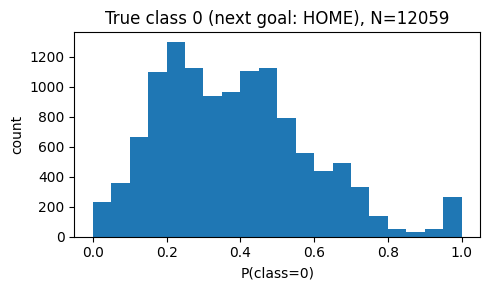

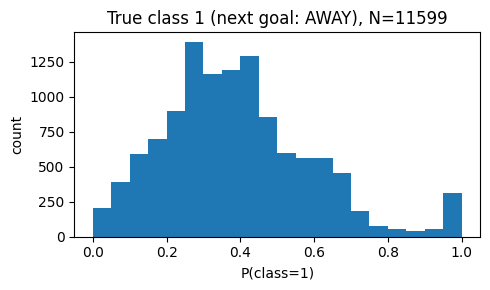

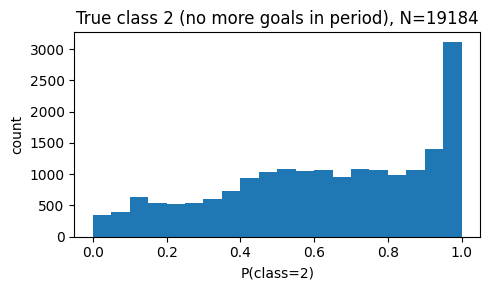

In [7]:
class_names = {
    0: "next goal: HOME",
    1: "next goal: AWAY",
    2: "no more goals in period"
}

for k in [0, 1, 2]:
    mask_k = (y_true == k)
    if mask_k.sum() == 0:
        print(f"\nNo samples with true class {k}")
        continue

    probs_k = probs[mask_k, k]  # вероятность правильного класса на этих примерах

    plt.figure(figsize=(5,3))
    plt.hist(probs_k, bins=20, range=(0, 1))
    plt.title(f"True class {k} ({class_names[k]}), N={mask_k.sum()}")
    plt.xlabel(f"P(class={k})")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()
